In [3]:
import os
import pandas as pd
import numpy as np

folder_path = os.path.join("..","Data","Preprocessed")
# Get all the files in the folder
files = os.listdir(folder_path)
# Iterate through all the files and save the data in a pandas dataframe
data = pd.DataFrame()
subjects_amount = 0
long_trials = 0
nan_trials = 0
for file in files:
    if file.endswith('.csv') or file.endswith('.xlsx'):
        file_data = pd.read_csv(os.path.join(folder_path, file)) if file.endswith('.csv') else pd.read_excel(os.path.join(folder_path, file))
        file_data = file_data[['random_ID','CONTEXT', 'TARGET', 'MEM_SET_SIZE', 'VISUAL_SET_SIZE', 'key_resp.rt', 'key_resp.corr','FILE_SEARCH_IMAGE']]
        file_data.columns = ['subject','context_present', 'target_present', 'mss', 'vss', 'rt', 'correct_response','stimulus']
        # Add a column with the subject number
        file_data['subject'] = file_data['subject'].iloc[0].astype(int)
        # Remove rows where the rt is NaN
        nan_trials += len(file_data[file_data.rt.isna()])
        file_data = file_data[file_data.rt.notna()]
        # Remove rows where the rt > 7 seconds, and add them to the long_trials variable
        long_trials += len(file_data[file_data.rt > 7.0])
        file_data = file_data[file_data.rt <= 7.0]
        # Append the data from the file to the dataframe if it passes the accuracy filter
        if file_data.correct_response.mean() >= 0.55:
            #use concat instead of append
            data = pd.concat([data, file_data])
            subjects_amount += 1
# Add to data the log Rts which are the log of the reaction times
data['log_mss'] = data.mss.apply(lambda x: 0 if x == 0 else np.log(x))
data['log_vss'] = data.vss.apply(lambda x: 0 if x == 0 else np.log(x))
# Filter correct responses
correct_data = data[data.correct_response == 1]
stimuli_to_reject = ['S1_building_026_person_012.jpg', 'S4_sky_004_kite_004.jpg', 'S4_mountain_026_horse_001.jpg', 'S4_shelves_029_book_002.jpg', 'S4_shelves_037_book_010.jpg', 'S4_jungle_009_bird_009.jpg']
correct_data = correct_data[~correct_data.stimulus.isin(stimuli_to_reject)]
TP_data = correct_data[correct_data.target_present == 1]
# Set FA_data as copy
FA_data = data[data.target_present == 0].copy()
FA_data = FA_data[~FA_data.stimulus.isin(stimuli_to_reject)]
FA_data.correct_response = 1-FA_data.correct_response

Accuracy: 0.6735563344380019 +- 0.010744300294288994
False Alarms: 0.26522468446773567 +- 0.009204312294324765
1.077074885153115
Mean accuracy for VSS 1 is 0.7494199535962877
Mean accuracy for VSS 2 is 0.6357308584686775
Mean accuracy for VSS 4 is 0.593279258400927
Mean accuracy for VSS 8 is 0.550351288056206
Mean accuracy for MSS 1 is 0.9678714859437751
Mean accuracy for MSS 2 is 0.6799387442572741
Mean accuracy for MSS 4 is 0.593279258400927
Mean accuracy for MSS 8 is 0.5834292289988493


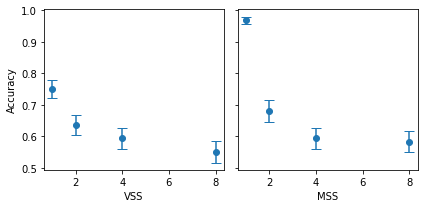

In [3]:
from scipy.stats import norm
#Compute the accuracy of the subjects, and then get the mean and standard error of the mean
TP_data_w_non_corrects = data[data.target_present == 1]
TP_data_w_non_corrects = TP_data_w_non_corrects[~TP_data_w_non_corrects.stimulus.isin(stimuli_to_reject)]
accuracy = TP_data_w_non_corrects.groupby('subject').correct_response.mean()
mean_accuracy = accuracy.mean()
std_error_accuracy = accuracy.sem()
print(f"Accuracy: {mean_accuracy} +- {std_error_accuracy}")

# Compute the false alarms of the target absent trials
false_alarm_rate = FA_data.groupby('subject').correct_response.mean()
mean_FA = false_alarm_rate.mean()
std_error_FA = false_alarm_rate.sem()
print(f"False Alarms: {mean_FA} +- {std_error_FA}")

# D prime calculation, z-score of the hit rate minus the z-score of the false alarm rate
# Compute d prime
d_prime = norm.ppf(mean_accuracy) - norm.ppf(mean_FA)

print(d_prime)


# Plot accuracy vs mss and accuracy vs vss
import matplotlib.pyplot as plt

from scipy.stats import t

VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])



fig, axs = plt.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True)



RT_means = []
RT_intervals = []

for vss in VSS:


    # I need to filter the dataframe to get only the rows that match the condition
    filtered_data = data[(data.target_present == 1) &(data.mss==4) &(data.vss==vss)& (~data.stimulus.isin(stimuli_to_reject))]


    print(f'Mean accuracy for VSS {vss} is {filtered_data.correct_response.mean()}')
    RT_means.append(filtered_data.correct_response.mean())
    ts = t.ppf([0.025,0.975], filtered_data.correct_response.size-1)
    RT_intervals.append(ts[1]*filtered_data.correct_response.std()/np.sqrt(filtered_data.correct_response.size))


axs[0].errorbar(VSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI')


RT_means = []
RT_intervals = []

for mss in MSS:

    filtered_data = data[(data.target_present == 1)&(data.vss==4) &(data.mss==mss) & (~data.stimulus.isin(stimuli_to_reject))]
    print(f'Mean accuracy for MSS {mss} is {filtered_data.correct_response.mean()}')
    RT_means.append(filtered_data.correct_response.mean())
    ts = t.ppf(0.975, filtered_data.correct_response.size-1)
    RT_intervals.append(ts*filtered_data.correct_response.std()/np.sqrt(filtered_data.correct_response.size))



axs[1].errorbar(MSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI')


axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('VSS')
axs[1].set_xlabel('MSS')

#Show in the plots that the first row is for target present and the second row is for target absent
#Set the y axis from 0.5 to 3.8, and y labels only in 1, 2 and 3

#Print accuracy across all the data

plt.tight_layout()
plt.show()
plt.close()



Slope:0.12 Intercept:1.86 CP: True
R2 0.8058863039630547
Slope:0.13 Intercept:1.33 CP: False
R2 0.9622305895801142
Slope: 0.58 Intercept: 1.44 CP: True
R2 0.7003874981281688
Slope: 0.38 Intercept: 1.29 CP: False
R2 0.9077606578407464


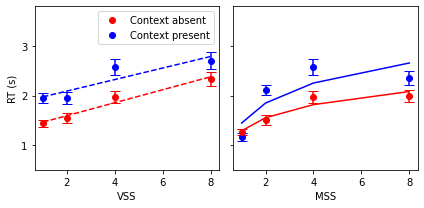

In [4]:
# Figura 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from scipy.stats import t
from sklearn.metrics import r2_score

VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])



fig, axs = plt.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True)

# I need a ParameterGrid to iterate over all possible combinations of parameters
grid_1 = ParameterGrid({'mss': [4], 'context_present': [True, False], 'target_present': [True]})
grid_2 = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True]})
# I need a dictionary saying in which subplot to plot each condition
# For grid_1, target present goes in the first row and the first column, target absent goes in the second row and the first column
# For grid_2, target present goes in the first row and the second column, target absent goes in the second row and the second column

color = {False: 'red', True: 'blue'}
# In grid_1 I iterate over VSS, in grid_2 I iterate over MSS
# First I iterate over grid_1 to get the mean and 95% CI of the rt for each combination of context_present, target_present, mss and vss of the subjects




for condition in grid_1:
    RT_means = []
    RT_intervals = []
    
    for vss in VSS:

        condition['vss'] = vss
        # I need to filter the dataframe to get only the rows that match the condition
        filtered_data = TP_data[(TP_data.context_present == condition['context_present']) & (TP_data.target_present == condition['target_present']) & (TP_data.mss == condition['mss']) & (TP_data.vss == condition['vss'])]
        # remove images S4_sky_004_kite_004.jpg S4_shelves_001_pottedplant_001.jpg S4_shelves_027_vase_003.jpg S4_shelves_037_book_010.jpg S1_building_033_cat_012.jpg S2_mountain_006_bear_002.jpg


        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf([0.025,0.975], filtered_data.rt.size-1)
        RT_intervals.append(ts[1]*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))


    axs[0].errorbar(VSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    axs[0].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])
    # Print fit parameters
    print("Slope:"+format(np.polyfit(VSS, RT_means, 1)[0],'.2f'),"Intercept:"+format(np.polyfit(VSS, RT_means, 1)[1],'.2f'),"CP: " + str(condition['context_present']))
    # Print the R2 of the linear fit
    print("R2",r2_score(RT_means, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS)))
colors = ["red","blue"]
# create handles list with lines using the colors
handles = [plt.Line2D([],[],color=colors[i], marker='o', linestyle='None') for i in range(len(colors))]
for condition in grid_2:
    RT_means = []
    RT_intervals = []
    
    for mss in MSS:

        condition['mss'] = mss
        filtered_data = TP_data[(TP_data.context_present == condition['context_present']) & (TP_data.target_present == condition['target_present']) & (TP_data.mss == condition['mss']) & (TP_data.vss == condition['vss'])]

        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf(0.975, filtered_data.rt.size-1)
        RT_intervals.append(ts*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))



    axs[1].errorbar(MSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    #Plot logaritmic fit
    axs[1].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])
    print("Slope: "+format(np.polyfit(np.log(MSS), RT_means, 1)[0],'.2f'),"Intercept: "+format(np.polyfit(np.log(MSS), RT_means, 1)[1],'.2f'),"CP: " + str(condition['context_present']))
    print("R2",r2_score(RT_means, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS))))

axs[0].set_ylabel('RT (s)')
axs[0].set_xlabel('VSS')
axs[1].set_xlabel('MSS')
axs[0].legend(handles=handles, labels=['Context absent', 'Context present'])
#Show in the plots that the first row is for target present and the second row is for target absent
#Set the y axis from 0.5 to 3.8, and y labels only in 1, 2 and 3
axs[0].set_ylim(0.5, 3.8)
axs[0].set_yticks([1, 2, 3])

plt.tight_layout()
plt.show()
plt.close()

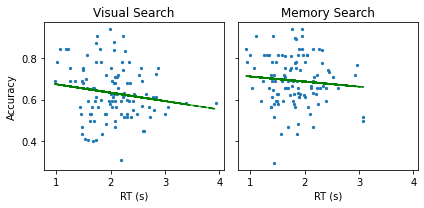

In [5]:
# Figura 3

fig, axs = plt.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True)

full_data_TP = data[data.target_present == True]


left_panel_rts = TP_data[TP_data.mss == 4][['subject','rt']].groupby('subject').mean()
left_panel_accuracy = full_data_TP[full_data_TP.mss == 4][['subject','correct_response']].groupby('subject').mean()
right_panel_rts = TP_data[TP_data.vss == 4][['subject','rt']].groupby('subject').mean()
right_panel_accuracy = full_data_TP[full_data_TP.vss == 4][['subject','correct_response']].groupby('subject').mean()
#scatter with small dots
axs[0].scatter(left_panel_rts,left_panel_accuracy, s=5)
axs[1].scatter(right_panel_rts,right_panel_accuracy, s=5)
#Linear fit in green dotted line
axs[0].plot(left_panel_rts, np.poly1d(np.polyfit(left_panel_rts.rt, left_panel_accuracy.correct_response, 1))(left_panel_rts.rt), '--', color='green')
axs[1].plot(right_panel_rts, np.poly1d(np.polyfit(right_panel_rts.rt, right_panel_accuracy.correct_response, 1))(right_panel_rts.rt), '--', color='green')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('RT (s)')
axs[1].set_xlabel('RT (s)')
axs[0].set_title('Visual Search')
axs[1].set_title('Memory Search')

plt.tight_layout()
plt.show()  
plt.close()

In [6]:
#Table 1
#Hacer los ajustes de la Fig. 2 pero por sujeto y después armar una tabla con R2 promedio entre sujetos para cada condicion (+error entre sujetos). Solo trials correctos.
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import wilcoxon
from sklearn.model_selection import ParameterGrid
# I need a ParameterGrid to iterate over all possible combinations of parameters
grid_1 = ParameterGrid({'vss': [4], 'context_present': [True, False]})
grid_2 = ParameterGrid({'mss': [4], 'context_present': [True, False]})


MSS = np.array([1, 2, 4, 8])
VSS = np.array([1, 2, 4, 8])
results_df = pd.DataFrame(columns=['context_present','linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])
for condition in grid_1:    
    filtered_data = TP_data[(TP_data.context_present == condition['context_present']) & (TP_data.vss == condition['vss'])]
    # I need to fit a linear regression and a logarithmic regression to the data, grouped by subject and get the R2 of each subject, and then get the mean of the R2 of all subjects
    # First i need to get the rts of each subject
    rts_by_subject = filtered_data[['subject','rt','mss']].groupby('subject')
    # Then i needd to fit the linear regression and the logarithmic regression to the data of each subject
    linear_r2 = []
    logarithmic_r2 = []
    a = []
    b = []
    log_a = []
    log_b = []
    for subject, values in rts_by_subject:
        rt_means = []
        valid_mss = []
        for mss in MSS:
            # Get the mean of the rts grouped by mss
            rts = values[values.mss == mss][['rt','mss']].mean()
            if len(rts) > 0 and not np.isnan(rts.iloc[0]):
                rt_means.append(rts.iloc[0])
                valid_mss.append(mss)
        linear_regression = np.poly1d(np.polyfit(valid_mss, rt_means, 1))
        logarithmic_regression = np.poly1d(np.polyfit(np.log(valid_mss), rt_means, 1))  
        a.append(np.polyfit(valid_mss, rt_means, 1)[0])
        b.append(np.polyfit(valid_mss, rt_means, 1)[1])   
        log_a.append(np.polyfit(np.log(valid_mss), rt_means, 1)[0])
        log_b.append(np.polyfit(np.log(valid_mss), rt_means, 1)[1])               
        # Get the R2 of the linear regression
        linear_r2.append(r2_score(rt_means, linear_regression(valid_mss)))
        # Get the R2 of the logarithmic regression
        logarithmic_r2.append(r2_score(rt_means, logarithmic_regression(np.log(valid_mss))))     
    # Then i need to get the mean of the R2 of each condition
    print("Condition: ",condition['context_present']," VSS: ",condition['vss'])
    print("Linear slope mean: ",np.mean(a)," Linear intercept mean: ",np.mean(b)," Logarithmic slope mean: ",np.mean(log_a)," Logarithmic intercept mean: ",np.mean(log_b))
    print("SEM Linear slope: ",np.std(a)/np.sqrt(len(a))," SEM Linear intercept: ",np.std(b)/np.sqrt(len(b))," SEM Logarithmic slope: ",np.std(log_a)/np.sqrt(len(log_a))," SEM Logarithmic intercept: ",np.std(log_b)/np.sqrt(len(log_b)))
    linear_r2_mean = np.mean(linear_r2)
    logarithmic_r2_mean = np.mean(logarithmic_r2)
    # I also need to get the error between subjects
    linear_r2_error = np.std(linear_r2)/np.sqrt(len(linear_r2))
    logarithmic_r2_error = np.std(logarithmic_r2)/np.sqrt(len(logarithmic_r2))
    # Then i need to add the results to the dataframe using concat
    wilcoxon_pvalue = wilcoxon(linear_r2, logarithmic_r2)[1]
    results_df = pd.concat([results_df, pd.DataFrame([[condition['context_present'], linear_r2_mean, logarithmic_r2_mean,linear_r2_error,logarithmic_r2_error,wilcoxon_pvalue]], columns=['context_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])])


# Set the index to context_present and target_present
results_df = results_df.set_index(['context_present'])
# Round the floats to 2 decimals
results_df = results_df.round(2)

print(results_df)

results_df = pd.DataFrame(columns=['context_present','linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])
for condition in grid_2:
    filtered_data = TP_data[(TP_data.context_present == condition['context_present']) & (TP_data.mss == condition['mss'])]
    # I need to fit a linear regression and a logarithmic regression to the data, grouped by subject and get the R2 of each subject, and then get the mean of the R2 of all subjects
    # First i need to get the rts of each subject
    rts_by_subject = filtered_data[['subject','rt','vss']].groupby('subject')
    # Then i needd to fit the linear regression and the logarithmic regression to the data of each subject
    linear_r2 = []
    logarithmic_r2 = []
    a = []
    b = []
    log_a = []
    log_b = []
    for subject, values in rts_by_subject:
        rt_means = []
        valid_vss = []
        for vss in VSS:
            # Get the mean of the rts grouped by mss
            rts = values[values.vss == vss][['rt','vss']].mean()
            if len(rts) > 0 and not np.isnan(rts.iloc[0]):
                rt_means.append(rts.iloc[0])
                valid_vss.append(vss)
        linear_regression = np.poly1d(np.polyfit(valid_vss, rt_means, 1))
        logarithmic_regression = np.poly1d(np.polyfit(np.log(valid_vss), rt_means, 1))  
        a.append(np.polyfit(valid_vss, rt_means, 1)[0])
        b.append(np.polyfit(valid_vss, rt_means, 1)[1])   
        log_a.append(np.polyfit(np.log(valid_vss), rt_means, 1)[0])
        log_b.append(np.polyfit(np.log(valid_vss), rt_means, 1)[1])              
        # Get the R2 of the linear regression
        linear_r2.append(r2_score(rt_means, linear_regression(valid_vss)))
        # Get the R2 of the logarithmic regression
        logarithmic_r2.append(r2_score(rt_means, logarithmic_regression(np.log(valid_vss))) )
    # Then i need to get the mean of the R2 of each condition
    print("Condition: ",condition['context_present']," MSS: ",condition['mss'])
    print("Linear slope mean: ",np.mean(a)," Linear intercept mean: ",np.mean(b)," Logarithmic slope mean: ",np.mean(log_a)," Logarithmic intercept mean: ",np.mean(log_b))
    print("SEM Linear slope: ",np.std(a)/np.sqrt(len(a))," SEM Linear intercept: ",np.std(b)/np.sqrt(len(b))," SEM Logarithmic slope: ",np.std(log_a)/np.sqrt(len(log_a))," SEM Logarithmic intercept: ",np.std(log_b)/np.sqrt(len(log_b)))

    linear_r2_mean = np.mean(linear_r2)
    logarithmic_r2_mean = np.mean(logarithmic_r2)
    # I also need to get the error between subjects
    linear_r2_error = np.std(linear_r2)/np.sqrt(len(linear_r2))
    logarithmic_r2_error = np.std(logarithmic_r2)/np.sqrt(len(logarithmic_r2))
    # Then i need to add the results to the dataframe using concat
    wilcoxon_pvalue = wilcoxon(linear_r2, logarithmic_r2)[1]
    results_df = pd.concat([results_df, pd.DataFrame([[condition['context_present'], linear_r2_mean, logarithmic_r2_mean,linear_r2_error,logarithmic_r2_error,wilcoxon_pvalue]], columns=['context_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])])

# Set the index to context_present and target_present
results_df = results_df.set_index(['context_present'])
# Round the floats to 2 decimals
results_df = results_df.round(2)
print(results_df)
# Resultados anteriores (replicando lo del paper, para asegurarme que lo estoy haciendo bien)    
#Linear R2 mean: 0.5709301680524412 for condition {'context_present': False, 'target_present': True, 'vss': 4}
#Logarithmic R2 mean: 0.6771224029463477 for condition {'context_present': False, 'target_present': True, 'vss': 4}
#Linear R2 mean: 0.5034891629625526 for condition {'context_present': True, 'target_present': True, 'vss': 4}
#Logarithmic R2 mean: 0.6550386960492629 for condition {'context_present': True, 'target_present': True, 'vss': 4}
#Linear R2 mean: 0.42546759794980626 for condition {'context_present': False, 'target_present': False, 'vss': 4}
#Logarithmic R2 mean: 0.5127272595858093 for condition {'context_present': False, 'target_present': False, 'vss': 4}
#Linear R2 mean: 0.4221564346252116 for condition {'context_present': True, 'target_present': False, 'vss': 4}
#Logarithmic R2 mean: 0.404421822847329 for condition {'context_present': True, 'target_present': False, 'vss': 4}

Condition:  True  VSS:  4
Linear slope mean:  0.1552083790882255  Linear intercept mean:  1.516713908877567  Logarithmic slope mean:  0.6360841586681222  Logarithmic intercept mean:  1.4315835944083695
SEM Linear slope:  0.014264898793580356  SEM Linear intercept:  0.05684682792236177  SEM Logarithmic slope:  0.04492242156737577  SEM Logarithmic intercept:  0.051363283511266025


/tmp/ipykernel_31577/2284262524.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[condition['context_present'], linear_r2_mean, logarithmic_r2_mean,linear_r2_error,logarithmic_r2_error,wilcoxon_pvalue]], columns=['context_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])])


Condition:  False  VSS:  4
Linear slope mean:  0.1195971689724341  Linear intercept mean:  1.2718226074423586  Logarithmic slope mean:  0.4072971981468502  Logarithmic intercept mean:  1.2767742469877346
SEM Linear slope:  0.012696701041890664  SEM Linear intercept:  0.04762715825491456  SEM Logarithmic slope:  0.033784052061054906  SEM Logarithmic intercept:  0.04251477924660105
                 linear R2  logarithmic R2  linear R2 standard error  \
context_present                                                        
True                  0.43            0.54                      0.03   
False                 0.51            0.54                      0.03   

                 logarithmic R2 standard error  p-value  
context_present                                          
True                                      0.03     0.00  
False                                     0.03     0.01  
Condition:  True  MSS:  4
Linear slope mean:  0.13242352170008068  Linear intercept mean:  1.836

/tmp/ipykernel_31577/2284262524.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[condition['context_present'], linear_r2_mean, logarithmic_r2_mean,linear_r2_error,logarithmic_r2_error,wilcoxon_pvalue]], columns=['context_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])])


Condition:  False  MSS:  4
Linear slope mean:  0.12671311497301607  Linear intercept mean:  1.3487707220936231  Logarithmic slope mean:  0.43456886174408366  Logarithmic intercept mean:  1.3701509042207796
SEM Linear slope:  0.01198035238348234  SEM Linear intercept:  0.052346368502507575  SEM Logarithmic slope:  0.0375008793421208  SEM Logarithmic intercept:  0.046914840307173966
                 linear R2  logarithmic R2  linear R2 standard error  \
context_present                                                        
True                  0.49            0.46                      0.03   
False                 0.54            0.52                      0.03   

                 logarithmic R2 standard error  p-value  
context_present                                          
True                                      0.03     0.13  
False                                     0.03     0.09  


In [7]:
#Fit ddm to all the data (TP)
import numpy as np
import pyddm

#Custom drift for pyddm
class DriftCustom(pyddm.models.Drift):
    name = "Custom Drift depending on MSS and context"
    required_parameters = ["driftmss", "context_present","bias"]
    required_conditions = ["mss", "context_present"]
    
    def get_drift(self, conditions, **kwargs):
        return self.driftmss/conditions['mss'] + self.context_present*conditions['context_present'] + self.bias
class BoundCustom(pyddm.models.Bound):
    name = "Custom bound depending on VSS and target"
    required_parameters = ["boundvss", "target_present","bias"]
    required_conditions = ["vss", "target_present"]

    def get_bound(self, conditions, **kwargs):
        return self.boundvss*conditions['vss'] + self.target_present*(1-conditions['target_present']) + self.bias
class OverlayCustom(pyddm.models.Overlay):
    name = "Custom overlay depending on context"
    required_parameters = ["nondectime","bias"]
    required_conditions = ["target_present"]

    def apply(self, solution):
        choice_upper = solution.choice_upper
        choice_lower = solution.choice_lower
        m = solution.model
        cond = solution.conditions
        undec = solution.undec
        evolution = solution.evolution
        shifts = int(((1-cond["target_present"])*self.nondectime + self.bias)/m.dt) # truncate
        newchoice_upper = np.zeros(choice_upper.shape, dtype=choice_upper.dtype)
        newchoice_lower = np.zeros(choice_lower.shape, dtype=choice_lower.dtype)
        if shifts > 0:
            newchoice_upper[shifts:] = choice_upper[:-shifts]
            newchoice_lower[shifts:] = choice_lower[:-shifts]
        elif shifts < 0:
            newchoice_upper[:shifts] = choice_upper[-shifts:]
            newchoice_lower[:shifts] = choice_lower[-shifts:]
        else:
            newchoice_upper = choice_upper
            newchoice_lower = choice_lower
        return pyddm.Solution(newchoice_upper, newchoice_lower, m, cond, undec, evolution)

m = pyddm.Model(drift=DriftCustom(driftmss=pyddm.Fittable(minval=0, maxval=5),bias=pyddm.Fittable(minval=0, maxval=5),context_present=pyddm.Fittable(minval=-5, maxval=0)), bound = BoundCustom(boundvss=pyddm.Fittable(minval=0, maxval=5),bias=pyddm.Fittable(minval=0, maxval=5),target_present=pyddm.Fittable(minval=0.5, maxval=1,default=0.75)),noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=0.1,maxval=1)), overlay=OverlayCustom(nondectime=pyddm.Fittable(minval=0.1,maxval=0.6),bias=pyddm.Fittable(minval=0.1,maxval=0.6)), T_dur=8,dt=0.001)
sample = pyddm.Sample.from_pandas_dataframe(TP_data, rt_column_name='rt', choice_column_name='correct_response')
m = pyddm.fit_adjust_model(sample,m,lossfunction= pyddm.models.loss.LossRobustLikelihood,verbose=False)

Info: Params [ 1.1176386  -0.25886997  1.09846251  0.99491803  0.10632396  0.91340696
  1.98087701  0.31356985  0.10109696] gave 4500.538006686723


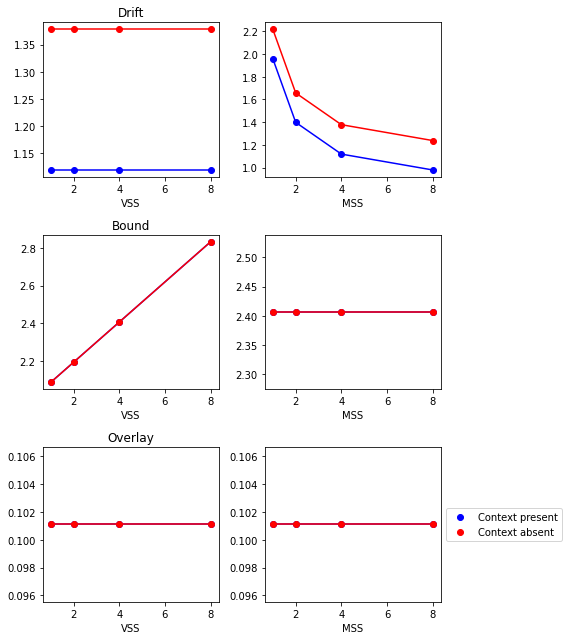

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
# Plot the parameter values for each condition

VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])

grid_1 = ParameterGrid({'mss': [4], 'context_present': [True, False], 'target_present': [True]})
grid_2 = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True]})

fig, axs = plt.subplots(3, 2, figsize=(8,9))
# For each parameter I need to plot the data for context present and context absent
# I need a grid with a color for each combination of target present and context present
color = {'context_present': 'blue', 'context_absent': 'red'}
# I need a grid to map each parameter to a subplot
axis_grid_1 = {'drift':axs[0, 0], 'bound':axs[1, 0], 'overlay':axs[2, 0]}
axis_grid_2 = {'drift':axs[0, 1], 'bound':axs[1, 1], 'overlay':axs[2, 1]}
# I need to set the title of each subplot to the parameter name
axs[0, 0].set_title('Drift')
axs[1, 0].set_title('Bound')
axs[2, 0].set_title('Overlay')

parameter_functions = {'drift': lambda x: x["driftmss"]/condition['mss']+ x["context_present"]*condition['context_present'] + x["bias"], 
                       'bound': lambda x: x["boundvss"]*condition['vss'] + x['target_present']*(1-condition['target_present']) + x["bias"], 
                       'overlay': lambda x: x["nondectime"]*(1-condition['target_present']) + x["bias"]}

handles = []
labels = ['Context present', 'Context absent']
# I need to iterate through the parameters
for parameter in ['drift', 'bound', 'overlay']:
    # I need to iterate through the grids
    for grid in [grid_1, grid_2]:
        # I need to iterate through the conditions
        for condition in grid:
            # I need to filter the dataframe to get only the rows that match the condition
            # Now I need to plot the data
            context_present_string = 'context_present' if condition['context_present'] else 'context_absent'
            parameter_values = []
            parameters_standard_error = []
            if grid == grid_1:
                
                for vss in VSS:
                    condition['vss'] = vss
                    parameter_value = parameter_functions[parameter](m.parameters()[parameter])
                    parameter_values.append(parameter_value)
                axis_grid_1[parameter].plot(VSS, parameter_values,marker='o',color=color[context_present_string])

            else:
                for mss in MSS:
                    condition['mss'] = mss
                    parameter_value = parameter_functions[parameter](m.parameters()[parameter])
                    parameter_values.append(parameter_value)
                axis_grid_2[parameter].plot(MSS, parameter_values,marker='o',color=color[context_present_string])



# Get the handles and labels according to the "color" dictionary and the "labels" list
for key in color:
    handles.append(plt.Line2D([0,0],[0,0],color=color[key], marker='o', linestyle=''))
for i in range(len(axs)):
    axs[i, 0].set_xlabel('VSS')
    axs[i, 1].set_xlabel('MSS')

plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
plt.close()

0.09 1.82 CP: True
0.08 1.54 CP: False
0.54 1.39 CP: True
0.41 1.23 CP: False


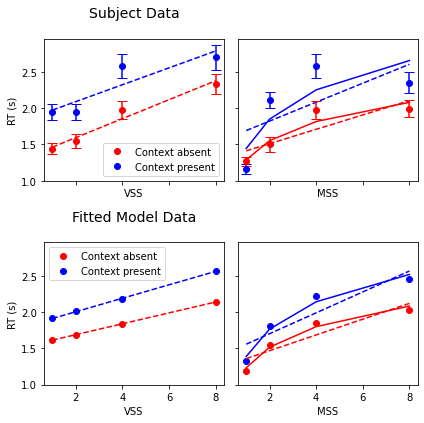

In [9]:
# Figura 4: Figura 2 pero con datos reales y modelo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyddm
from sklearn.model_selection import ParameterGrid
from scipy.stats import t
from IPython.display import clear_output

VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])


fig, axs = plt.subplots(2, 2, figsize=(6,6), sharex=True, sharey=True)



# Now I proceed with step 1
# I need a ParameterGrid to iterate over all possible combinations of parameters
grid_1 = ParameterGrid({'mss': [4], 'context_present': [True, False], 'target_present': [True]})
grid_2 = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True]})
# I need a dictionary saying in which subplot to plot each condition
# For grid_1, target present goes in the first row and the first column, target absent goes in the second row and the first column
# For grid_2, target present goes in the first row and the second column, target absent goes in the second row and the second column
grid_1_subplot_dict = {'target_present': {True: axs[0, 0], False: axs[1, 0]}}
grid_2_subplot_dict = {'target_present': {True: axs[0, 1], False: axs[1, 1]}}
color = {False: 'red', True: 'blue'}
# In grid_1 I iterate over VSS, in grid_2 I iterate over MSS
# First I iterate over grid_1 to get the mean and 95% CI of the rt for each combination of context_present, target_present, mss and vss of the subjects




for condition in grid_1:
    RT_means = []
    RT_intervals = []
    
    for vss in VSS:

        condition['vss'] = vss
        # I need to filter the dataframe to get only the rows that match the condition
        filtered_data = TP_data[(TP_data.context_present == condition['context_present']) & (TP_data.target_present == condition['target_present']) & (TP_data.mss == condition['mss']) & (TP_data.vss == condition['vss'])]
        # remove images S4_sky_004_kite_004.jpg S4_shelves_001_pottedplant_001.jpg S4_shelves_027_vase_003.jpg S4_shelves_037_book_010.jpg S1_building_033_cat_012.jpg S2_mountain_006_bear_002.jpg


        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf([0.025,0.975], filtered_data.rt.size-1)
        RT_intervals.append(ts[1]*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))


    axs[0,0].errorbar(VSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    axs[0,0].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])

colors = ["red","blue"]
# create handles list with lines using the colors
handles = [plt.Line2D([],[],color=colors[i], marker='o', linestyle='None') for i in range(len(colors))]
for condition in grid_2:
    RT_means = []
    RT_intervals = []
    
    for mss in MSS:

        condition['mss'] = mss
        filtered_data = TP_data[(TP_data.context_present == condition['context_present']) & (TP_data.target_present == condition['target_present']) & (TP_data.mss == condition['mss']) & (TP_data.vss == condition['vss'])]

        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf(0.975, filtered_data.rt.size-1)
        RT_intervals.append(ts*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))



    axs[0,1].errorbar(MSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    axs[0,1].plot(MSS, np.poly1d(np.polyfit(MSS, RT_means, 1))(MSS), '--', color=color[condition['context_present']])
    #Plot logaritmic fit
    axs[0,1].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])


axs[0,0].set_ylabel('RT (s)')
axs[0,0].set_xlabel('VSS')
axs[0,1].set_xlabel('MSS')
axs[0,0].legend(handles=handles, labels=['Context absent', 'Context present'])

# Now I proceed with step 2

# Initialize a dataframe to store the parameters of the model and the parameters of the grid
model_parameters = pd.DataFrame(columns=['drift', 'noise', 'bound', 'overlay', 'T_dur', 'mss', 'vss', 'context_present', 'target_present'])


# I use the same grids as before
for condition in grid_1:
    RT_means = []
    RT_intervals = []
    for vss in VSS:
        condition['vss'] = vss
        # Now I need to fit the data to the model
        model_sample = m.solve(conditions=condition).resample(10000)
        rts = model_sample.choice_upper
        RT_means.append(np.mean(rts))
        RT_intervals.append(t.ppf(0.975, len(rts)-1)*np.std(rts)/np.sqrt(len(rts)))
    axs[1,0].scatter(MSS, RT_means, label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    axs[1,0].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])
    print(format(np.polyfit(VSS, RT_means, 1)[0],'.2f'),format(np.polyfit(VSS, RT_means, 1)[1],'.2f'),"CP: " + str(condition['context_present']))
for condition in grid_2:
    RT_means = []
    RT_intervals = []
    for mss in MSS:
        condition['mss'] = mss
        model_sample = m.solve(conditions=condition).resample(10000)
        rts = model_sample.choice_upper
        RT_means.append(np.mean(rts))
        RT_intervals.append(t.ppf(0.975, len(rts)-1)*np.std(rts)/np.sqrt(len(rts)))
    axs[1,1].scatter(MSS, RT_means, label='Mean and 95% CI',color=color[condition['context_present']])
    axs[1,1].plot(MSS, np.poly1d(np.polyfit(MSS, RT_means, 1))(MSS), '--', color=color[condition['context_present']])
    #Plot logaritmic fit
    axs[1,1].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])
    print(format(np.polyfit(np.log(MSS), RT_means, 1)[0],'.2f'),format(np.polyfit(np.log(MSS), RT_means, 1)[1],'.2f'),"CP: " + str(condition['context_present']))
axs[1,0].set_ylabel('RT (s)')
axs[1,0].set_xlabel('VSS')
axs[1,1].set_xlabel('MSS')
axs[1,0].legend(handles=handles, labels=['Context absent', 'Context present'])
#Show in the plots that the first row is for target present and the second row is for target absent

# Place a text on top of the first 4 plots that says "Subject Data", and on top of the last 4 plots that says "Fitted Model Data"
axs[0, 0].text(0.5, 1.15, 'Subject Data', horizontalalignment='center', fontsize=14, transform=axs[0, 0].transAxes)
axs[1, 0].text(0.5, 1.15, 'Fitted Model Data', horizontalalignment='center', fontsize=14, transform=axs[1, 0].transAxes)


plt.tight_layout()
plt.show()
plt.close()

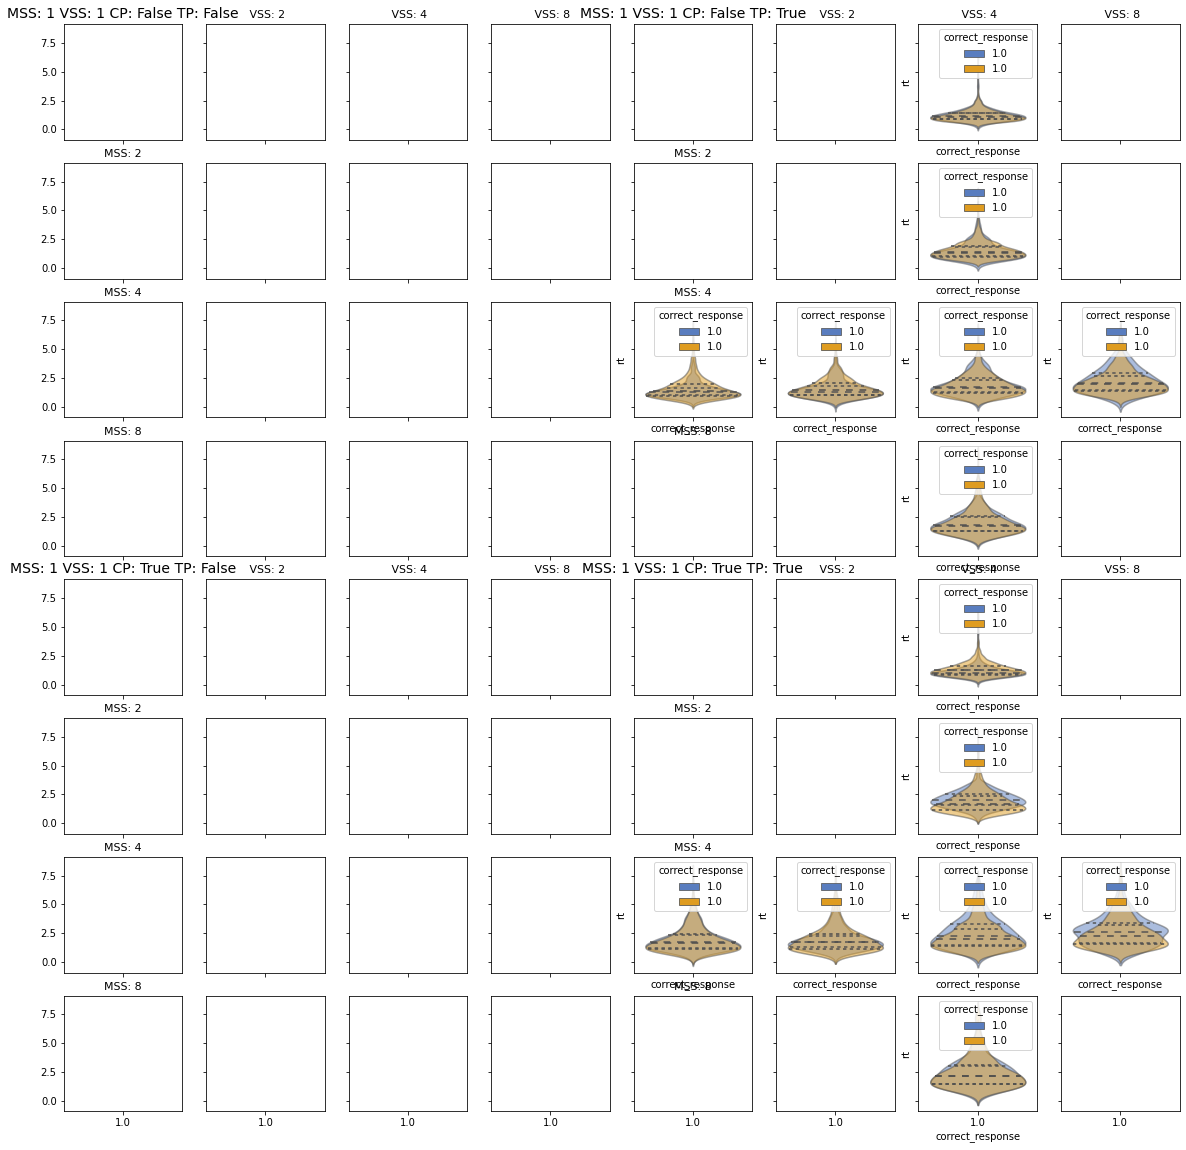

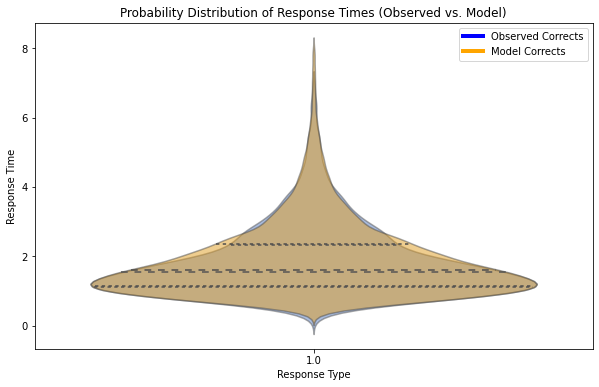

In [10]:
# Suplementario: Violines
import numpy as np
from sklearn.model_selection import ParameterGrid
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns

#Grid to iterate over all possible combinations of parameters
grid = ParameterGrid({'mss': [1, 2, 4, 8], 'vss': [1, 2, 4, 8], 'context_present': [True, False], 'target_present': [True, False]})

#I need a grid of plots to plot the data for each combination of parameters, there would be 64 plots
fig, axs = plt.subplots(8, 8, figsize=(20,20), sharex=True, sharey=True)

# I need to map each combination of parameters to a subplot

model_sample_corrects = np.array([])
model_sample_errors = np.array([])
combined_model_data = np.array([])
for condition in grid:
    filtered_data = TP_data[(TP_data.context_present == condition['context_present']) & (TP_data.target_present == condition['target_present']) & (TP_data.mss == condition['mss']) & (TP_data.vss == condition['vss'])]
    title = ""
    ax_index_x = int(np.log2(condition['mss'])) + 4*condition['context_present']
    ax_index_y = int(np.log2(condition['vss'])) + 4*condition['target_present']
    fontsize = 11
    if np.mod(ax_index_y,4) ==0:
        title += "MSS: " + str(condition['mss'])
    if np.mod(ax_index_x,4) ==0:
        title += " VSS: " + str(condition['vss'])
    if np.mod(ax_index_x,4) ==0 and np.mod(ax_index_y,4) ==0:
        title += " CP: " + str(condition['context_present'])
        fontsize = 14
    if np.mod(ax_index_x,4) ==0 and np.mod(ax_index_y,4) ==0:
        title += " TP: " + str(condition['target_present'])
        fontsize = 14
    
    axs[ax_index_x, ax_index_y].set_title(title, fontsize=fontsize)
    
    
    if len(filtered_data) == 0:
        continue
    sample = m.solve(conditions=condition).resample(1000)
    model_sample_corrects = np.concatenate([model_sample_corrects, sample.choice_upper])
    model_sample_errors = np.concatenate([model_sample_errors, sample.choice_lower])
    combined_model_data = np.concatenate([combined_model_data, np.concatenate([sample.choice_upper, sample.choice_lower])])
    #Do a violin plot for the model data and for the observed data in the corresponding subplot according to the condition

    # Create a DataFrame for combined model data
    model_df = pd.DataFrame({
        'correct_response': np.ones_like(sample.choice_upper),
        'rt': sample.choice_upper
    })

    
    violin = sns.violinplot(x="correct_response", y="rt", data=filtered_data,  inner="quart", hue = "correct_response",
               palette="muted", density_norm="count", common_norm=True,alpha=0.3,ax=axs[ax_index_x, ax_index_y],legend=False)
    plt.setp(violin.collections, alpha=.5)
    violin = sns.violinplot(x="correct_response", y="rt", data=model_df,  inner="quart", hue = "correct_response",
                palette={1.0:"orange"}, density_norm="count", common_norm=True,alpha=0.3,ax=axs[ax_index_x, ax_index_y],legend=False)
    plt.setp(violin.collections, alpha=.5)
plt.show()

# Create a DataFrame for combined model data
model_df = pd.DataFrame({
    'correct_response': np.ones_like(model_sample_corrects),
    'rt': model_sample_corrects
})



# Create a violin plot for observed data
plt.figure(figsize=(10, 6))

violin = sns.violinplot(x="correct_response", y="rt", data=TP_data,  inner="quart", hue = "correct_response",
               palette="muted", density_norm="count", common_norm=True)
plt.setp(violin.collections, alpha=.5)
# Create a violin plot for combined model data
violin = sns.violinplot(x="correct_response", y="rt", data=model_df,  inner="quart", hue = "correct_response",
               palette={1.0:"orange"}, density_norm="count", common_norm=True)
plt.setp(violin.collections, alpha=.5)
# Set plot labels and title
plt.xlabel("Response Type")
plt.ylabel("Response Time")
plt.title("Probability Distribution of Response Times (Observed vs. Model)")

# Create lines for the legend with the same colors as the violin plots
from matplotlib.lines import Line2D

orange_line = Line2D([0], [0], color='orange', lw=4)
blue_line = Line2D([0], [0], color='blue', lw=4)

handles = [blue_line, orange_line]

# Show legend
plt.legend(handles=handles,labels=["Observed Corrects","Model Corrects"])

# Show the plot
plt.show()
plt.close()

Visual Search:
Condition: CP: True TP: True
Linear Slope: 0.12 Linear Intercept: 1.86
Logarithmic Slope: 0.42 Logarithmic Intercept: 1.86
Linear R2: 0.8058863039630547 Log R2: 0.8586993260874014
CI: [0.10764598624981989, 0.11532156757165973, 0.1641756962419403, 0.17062927974200287]
Condition: CP: True TP: False
Linear Slope: 0.19 Linear Intercept: 2.12
Logarithmic Slope: 0.74 Logarithmic Intercept: 2.07
Linear R2: 0.6457353394542529 Log R2: 0.8030111413945152
CI: [0.11267729533969621, 0.13462387717395913, 0.1418762139499578, 0.14907887145509136]
Condition: CP: False TP: True
Linear Slope: 0.13 Linear Intercept: 1.33
Logarithmic Slope: 0.45 Logarithmic Intercept: 1.35
Linear R2: 0.9622305895801142 Log R2: 0.9513249735863767
CI: [0.0752021032364337, 0.0959078662510252, 0.12105294285578899, 0.14111460621243593]
Condition: CP: False TP: False
Linear Slope: 0.26 Linear Intercept: 1.38
Logarithmic Slope: 0.91 Logarithmic Intercept: 1.41
Linear R2: 0.9686665307878699 Log R2: 0.987150201929794

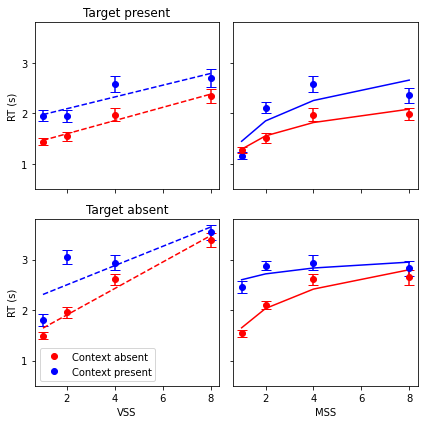

In [11]:
# Suplementario: Figura 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from scipy.stats import t
from sklearn.metrics import r2_score

VSS = np.array([1, 2, 4, 8])
MSS = np.array([1, 2, 4, 8])



fig, axs = plt.subplots(2, 2, figsize=(6,6), sharex=True, sharey=True)

# I need a ParameterGrid to iterate over all possible combinations of parameters
grid_1 = ParameterGrid({'mss': [4], 'context_present': [True, False], 'target_present': [True, False]})
grid_2 = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True, False]})
# I need a dictionary saying in which subplot to plot each condition
# For grid_1, target present goes in the first row and the first column, target absent goes in the second row and the first column
# For grid_2, target present goes in the first row and the second column, target absent goes in the second row and the second column
grid_1_subplot_dict = {'target_present': {True: axs[0, 0], False: axs[1, 0]}}
grid_2_subplot_dict = {'target_present': {True: axs[0, 1], False: axs[1, 1]}}
color = {False: 'red', True: 'blue'}
# In grid_1 I iterate over VSS, in grid_2 I iterate over MSS
# First I iterate over grid_1 to get the mean and 95% CI of the rt for each combination of context_present, target_present, mss and vss of the subjects



print("Visual Search:")
for condition in grid_1:
    RT_means = []
    RT_intervals = []
    
    for vss in VSS:

        condition['vss'] = vss
        # I need to filter the dataframe to get only the rows that match the condition
        filtered_data = correct_data[(correct_data.context_present == condition['context_present']) & (correct_data.target_present == condition['target_present']) & (correct_data.mss == condition['mss']) & (correct_data.vss == condition['vss'])]
        # remove images S4_sky_004_kite_004.jpg S4_shelves_001_pottedplant_001.jpg S4_shelves_027_vase_003.jpg S4_shelves_037_book_010.jpg S1_building_033_cat_012.jpg S2_mountain_006_bear_002.jpg


        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf([0.025,0.975], filtered_data.rt.size-1)
        RT_intervals.append(ts[1]*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))


    grid_1_subplot_dict['target_present'][condition['target_present']].errorbar(VSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    # Plot the linear regression with dotted lines
    grid_1_subplot_dict['target_present'][condition['target_present']].plot(VSS, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS), '--', color=color[condition['context_present']])
    print("Condition:","CP: " + str(condition['context_present']),"TP: " + str(condition['target_present']))
    print("Linear Slope: "+format(np.polyfit(VSS, RT_means, 1)[0],'.2f'),"Linear Intercept: "+format(np.polyfit(VSS, RT_means, 1)[1],'.2f'))
    print("Logarithmic Slope: "+format(np.polyfit(np.log(VSS), RT_means, 1)[0],'.2f'),"Logarithmic Intercept: "+format(np.polyfit(np.log(VSS), RT_means, 1)[1],'.2f'))
    print("Linear R2:",r2_score(RT_means, np.poly1d(np.polyfit(VSS, RT_means, 1))(VSS)), "Log R2:",r2_score(RT_means, np.poly1d(np.polyfit(np.log(VSS), RT_means, 1))(np.log(VSS))))
    print("CI:",RT_intervals)

colors = ["red","blue","green","orange"]
# create handles list with lines using the colors
handles = [plt.Line2D([],[],color=colors[i], marker='o', linestyle='None') for i in range(len(colors))]
print("Memory Search:")
for condition in grid_2:
    RT_means = []
    RT_intervals = []
    
    for mss in MSS:

        condition['mss'] = mss
        filtered_data = correct_data[(correct_data.context_present == condition['context_present']) & (correct_data.target_present == condition['target_present']) & (correct_data.mss == condition['mss']) & (correct_data.vss == condition['vss'])]

        RT_means.append(filtered_data.rt.mean())
        ts = t.ppf(0.975, filtered_data.rt.size-1)
        RT_intervals.append(ts*filtered_data.rt.std()/np.sqrt(filtered_data.rt.size))



    grid_2_subplot_dict['target_present'][condition['target_present']].errorbar(MSS, RT_means, yerr=RT_intervals, fmt='o', capsize=5, label='Mean and 95% CI',color=color[condition['context_present']])
    #Plot logaritmic fit
    grid_2_subplot_dict['target_present'][condition['target_present']].plot(MSS, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS)), color=color[condition['context_present']])
    print("Condition:","CP: " + str(condition['context_present']),"TP: " + str(condition['target_present']))
    print("Logarithmic Slope: "+format(np.polyfit(np.log(MSS), RT_means, 1)[0],'.2f'),"Logarithmic Intercept: "+format(np.polyfit(np.log(MSS), RT_means, 1)[1],'.2f'))
    print("Linear Slope: "+format(np.polyfit(MSS, RT_means, 1)[0],'.2f'),"Linear Intercept: "+format(np.polyfit(MSS, RT_means, 1)[1],'.2f'))
    print("Log R2:",r2_score(RT_means, np.poly1d(np.polyfit(np.log(MSS), RT_means, 1))(np.log(MSS))),"Linear R2:",r2_score(RT_means, np.poly1d(np.polyfit(MSS, RT_means, 1))(MSS)))  
    print("CI:",RT_intervals)

axs[0, 0].set_ylabel('RT (s)')
axs[1, 0].set_ylabel('RT (s)')
axs[1, 0].set_xlabel('VSS')
axs[1, 1].set_xlabel('MSS')
axs[1,0].legend(handles=handles,labels=['Context absent', 'Context present'])
#Show in the plots that the first row is for target present and the second row is for target absent
axs[0, 0].set_title('Target present')
axs[1, 0].set_title('Target absent')
axs[0, 0].set_ylim(0.5, 3.8)
axs[0, 0].set_yticks([1, 2, 3])
axs[1, 0].set_ylim(0.5, 3.8)
axs[1, 0].set_yticks([1, 2, 3])
plt.tight_layout()
plt.show()
plt.close()

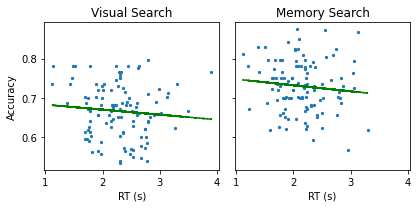

In [12]:
# Suplementario: Figura 3
# Accuracy x correct RTs
# MSS fixed at 4 for left panel
# VSS fixed at 4 for right panel
fig, axs = plt.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True)

# For left panel i need to get the rts of correct_data filtered by mss = 4 and grouped by subject, and then get the mean of each subject. I also need to get the accuracy of each subject from data
# For right panel i need to get the rts of correct_data filtered by vss = 4 and grouped by subject, and then get the mean of each subject. I also need to get the accuracy of each subject from data
left_panel_rts = correct_data[correct_data.mss == 4][['subject','rt']].groupby('subject').mean()
left_panel_accuracy = data[data.mss == 4][['subject','correct_response']].groupby('subject').mean()
right_panel_rts = correct_data[correct_data.vss == 4][['subject','rt']].groupby('subject').mean()
right_panel_accuracy = data[data.vss == 4][['subject','correct_response']].groupby('subject').mean()
#scatter with small dots
axs[0].scatter(left_panel_rts,left_panel_accuracy, s=5)
axs[1].scatter(right_panel_rts,right_panel_accuracy, s=5)
#Linear fit in green dotted line
axs[0].plot(left_panel_rts, np.poly1d(np.polyfit(left_panel_rts.rt, left_panel_accuracy.correct_response, 1))(left_panel_rts.rt), '--', color='green')
axs[1].plot(right_panel_rts, np.poly1d(np.polyfit(right_panel_rts.rt, right_panel_accuracy.correct_response, 1))(right_panel_rts.rt), '--', color='green')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('RT (s)')
axs[1].set_xlabel('RT (s)')
axs[0].set_title('Visual Search')
axs[1].set_title('Memory Search')

plt.tight_layout()
plt.show()  
plt.close()

In [13]:

# RT ~ Context[logical] + Target[logical] + MSS[linear] + (1 | subject) 
# RT ~ Context[logical] + Target[logical] + MSS[log] + (1 | subject) 
# RT ~ Context[logical] + Target[logical] + VSS[linear] + (1 | subject) 
# RT ~ Context[logical] + Target[logical] + VSS[log] + (1 | subject) 

from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri


# Activate automatic conversion
pandas2ri.activate()



# Define a function to fit LMM and calculate AIC or BIC
def fit_lmm_and_get_criteria_for_subject(data, formula_1,formula_2,formula_3,formula_4,formula_5,file_path_1,file_path_2):


    r_data = pandas2ri.py2rpy(data.reset_index())

    # Get cwd
    current_dir = os.getcwd()

    # Pass the data to R environment
    ro.r.assign('data', r_data)

    ro.r(f'setwd("{current_dir}")')

    value = formula_2.split('*')[1].split('+')[0]


    r_script = f'''library(lme4)
library(sjPlot)
library(ggplot2)
library(MuMIn)
library(lattice)


    # Fit the linear mixed-effects model
model_1 <- lmer({formula_1}, data = data)

# Get model summary


    # Fit the linear mixed-effects model
model_2 <- lmer({formula_2}, data = data)

# Get model summary


model_3 <- lmer({formula_3}, data = data)

model_4 <- lmer({formula_4}, data = data)

model_5 <- lmer({formula_5}, data = data)

model_summary <- tab_model(model_5,show.re.var=FALSE,show.aic=TRUE,file="{file_path_1}")
print(model_summary)

model_summary <- tab_model(model_2,show.re.var=FALSE,show.aic=TRUE,file="{file_path_2}")
print(model_summary)

# Save dotplot to file
png("{file_path_2[:-5]}_dotplot.png")
print(dotplot(ranef(model_5, condVar=TRUE,whichel='subject')))
dev.off()

data$context_present <- as.factor(data$context_present)
data$predicted <- predict(model_2)

# Create the base plot
base_plot <- ggplot(data, aes(x = {value}, y = rt, color = context_present)) +
             geom_point(alpha = 0.5) + # Original data points
             geom_smooth(method = "lm", se = TRUE, aes(y = predicted), size = 1) +
             facet_wrap(~ context_present) + # Facet by context_present
             ggtitle("Predicted Reaction Times with Original Data Points and Confidence Intervals")

# Save the plot to a file
ggsave(filename = "{file_path_2[:-5]}_fit_plot.png", plot = base_plot, width = 8, height = 6)

# Run anova between two models and print the results
anova_results <- anova(model_1,model_2,model_3,model_5)
print(anova_results)

'''

    # Execute the R script
    ro.r(r_script)
    
    return

formula_1 = 'rt ~ context_present*log_mss + (1|subject) + (1|stimulus)'
file_path_1="model_summary_1.html"
formula_2 = 'rt ~ context_present*log_mss + (1|subject)'
file_path_2="model_summary_2.html"
formula_3 = 'rt ~ context_present + (1|subject)'
formula_4 = 'rt ~ context_present*log_mss + (context_present|subject)'
formula_5 = 'rt ~ context_present*log_mss + (context_present|subject)  + (1|stimulus)'

fit_lmm_and_get_criteria_for_subject(TP_data, formula_1,formula_2,formula_3,formula_4,formula_5,file_path_1,file_path_2)

formula_1 = 'rt ~ context_present*vss + (1|subject) + (1|stimulus)'
file_path_1="model_summary_3.html"
formula_2 = 'rt ~ context_present*vss + (1|subject)'
file_path_2="model_summary_4.html"
formula_3 = 'rt ~ context_present + (1|subject)'
formula_4 = 'rt ~ context_present*vss + (context_present|subject)'
formula_5 = 'rt ~ context_present*vss + (context_present|subject)  + (1|stimulus)'

fit_lmm_and_get_criteria_for_subject(TP_data, formula_1,formula_2,formula_3,formula_4,formula_5,file_path_1,file_path_2)

formula_1 = 'rt ~ context_present*mss + (1|subject) + (1|stimulus)'
file_path_1="model_summary_5.html"
formula_2 = 'rt ~ context_present*mss + (1|subject)'
file_path_2="model_summary_6.html"
formula_3 = 'rt ~ context_present + (1|subject)'
formula_4 = 'rt ~ context_present*mss + (context_present|subject)'
formula_5 = 'rt ~ context_present*mss + (context_present|subject)  + (1|stimulus)'

fit_lmm_and_get_criteria_for_subject(TP_data, formula_1,formula_2,formula_3,formula_4,formula_5,file_path_1,file_path_2)

formula_1 = 'rt ~ context_present*log_vss + (1|subject) + (1|stimulus)'
file_path_1="model_summary_7.html"
formula_2 = 'rt ~ context_present*log_vss + (1|subject)'
file_path_2="model_summary_8.html"
formula_3 = 'rt ~ context_present + (1|subject)'
formula_4 = 'rt ~ context_present*log_vss + (context_present|subject)'
formula_5 = 'rt ~ context_present*log_vss + (context_present|subject) + (1|stimulus)'

fit_lmm_and_get_criteria_for_subject(TP_data, formula_1,formula_2,formula_3,formula_4,formula_5,file_path_1,file_path_2)

R[write to console]: Cargando paquete requerido: Matrix

R[write to console]: Learn more about sjPlot with 'browseVignettes("sjPlot")'.

R[write to console]: Error en library(MuMIn): no hay paquete llamado ‘MuMIn’



RRuntimeError: Error en library(MuMIn): no hay paquete llamado ‘MuMIn’


In [14]:
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri


# Activate automatic conversion
pandas2ri.activate()



# Define a function to fit LMM and calculate AIC or BIC for each subject
def fit_lmm_and_get_criteria_for_subject(data, formula,file_path):

    # Assuming your pandas DataFrame is named 'data_df'
    r_data = pandas2ri.py2rpy(data.reset_index())

    # Get cwd
    current_dir = os.getcwd()

    # Pass the data to R environment
    ro.r.assign('data', r_data)

    ro.r(f'setwd("{current_dir}")')


    r_script = f'''library(lme4)
library(sjPlot)


    # Fit the linear mixed-effects model
model <- glmer({formula}, data = data, family = binomial)

# Get model summary
model_summary <- tab_model(model,show.re.var=FALSE,show.aic=TRUE,file="{file_path}")
print(model_summary)

'''

    # Execute the R script
    ro.r(r_script)
    
    return

TP_data_full = data[data.target_present == True]

formula = 'correct_response ~ context_present*mss + (1|subject)'
file_path="model_summary_acc_1.html"
fit_lmm_and_get_criteria_for_subject(TP_data_full, formula,file_path)

formula = 'correct_response ~ context_present*log_mss + (1|subject)'
file_path="model_summary_acc_2.html"
fit_lmm_and_get_criteria_for_subject(TP_data_full, formula,file_path)

formula = 'correct_response ~ context_present*vss + (1|subject)'
file_path="model_summary_acc_3.html"
fit_lmm_and_get_criteria_for_subject(TP_data_full, formula,file_path)

formula = 'correct_response ~ context_present*log_vss + (1|subject)'
file_path="model_summary_acc_4.html"

fit_lmm_and_get_criteria_for_subject(TP_data_full, formula,file_path)


In [16]:
#Table 1
#Hacer los ajustes de la Fig. 2 pero por sujeto y después armar una tabla con R2 promedio entre sujetos para cada condicion (+error entre sujetos). Solo trials correctos.
from sklearn.metrics import r2_score
from scipy.stats import wilcoxon
# I need a ParameterGrid to iterate over all possible combinations of parameters
grid_1 = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True, False]})
grid_2 = ParameterGrid({'mss': [4], 'context_present': [True, False], 'target_present': [True, False]})



MSS = np.array([1, 2, 4, 8])
VSS = np.array([1, 2, 4, 8])
results_df = pd.DataFrame(columns=['context_present', 'target_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])
for condition in grid_1:    
    filtered_data = correct_data[(correct_data.context_present == condition['context_present']) & (correct_data.target_present == condition['target_present']) & (correct_data.vss == condition['vss'])]
    # I need to fit a linear regression and a logarithmic regression to the data, grouped by subject and get the R2 of each subject, and then get the mean of the R2 of all subjects
    # First i need to get the rts of each subject
    rts_by_subject = filtered_data[['subject','rt','mss']].groupby('subject')
    # Then i needd to fit the linear regression and the logarithmic regression to the data of each subject
    linear_r2 = []
    logarithmic_r2 = []
    for subject, values in rts_by_subject:
        rt_means = []
        valid_mss = []
        for mss in MSS:
            # Get the mean of the rts grouped by mss
            rts = values[values.mss == mss][['rt','mss']].mean()
            if len(rts) > 0 and not np.isnan(rts.iloc[0]):
                rt_means.append(rts.iloc[0])
                valid_mss.append(mss)
        linear_regression = np.poly1d(np.polyfit(valid_mss, rt_means, 1))
        logarithmic_regression = np.poly1d(np.polyfit(np.log(valid_mss), rt_means, 1))            
        # Get the R2 of the linear regression
        linear_r2.append(r2_score(rt_means, linear_regression(valid_mss)))
        # Get the R2 of the logarithmic regression
        logarithmic_r2.append(r2_score(rt_means, logarithmic_regression(np.log(valid_mss))))     
    # Then i need to get the mean of the R2 of each condition
    linear_r2_mean = np.mean(linear_r2)
    logarithmic_r2_mean = np.mean(logarithmic_r2)
    # I also need to get the error between subjects
    linear_r2_error = np.std(linear_r2)/np.sqrt(len(linear_r2))
    logarithmic_r2_error = np.std(logarithmic_r2)/np.sqrt(len(logarithmic_r2))
    # Then i need to add the results to the dataframe using concat
    wilcoxon_pvalue = wilcoxon(linear_r2, logarithmic_r2)[1]
    results_df = pd.concat([results_df, pd.DataFrame([[condition['context_present'], condition['target_present'], linear_r2_mean, logarithmic_r2_mean,linear_r2_error,logarithmic_r2_error,wilcoxon_pvalue]], columns=['context_present', 'target_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])])

# Set the index to context_present and target_present
results_df = results_df.set_index(['context_present', 'target_present'])
# Round the floats to 2 decimals
results_df = results_df.round(2)
print(results_df)
results_df = pd.DataFrame(columns=['context_present', 'target_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])
for condition in grid_2:    
    filtered_data = correct_data[(correct_data.context_present == condition['context_present']) & (correct_data.target_present == condition['target_present']) & (correct_data.mss == condition['mss'])]
    # I need to fit a linear regression and a logarithmic regression to the data, grouped by subject and get the R2 of each subject, and then get the mean of the R2 of all subjects
    # First i need to get the rts of each subject
    rts_by_subject = filtered_data[['subject','rt','vss']].groupby('subject')
    # Then i needd to fit the linear regression and the logarithmic regression to the data of each subject
    linear_r2 = []
    logarithmic_r2 = []
    for subject, values in rts_by_subject:
        rt_means = []
        valid_vss = []
        for vss in VSS:
            # Get the mean of the rts grouped by vss
            rts = values[values.vss == vss][['rt','vss']].mean()
            if len(rts) > 0 and not np.isnan(rts.iloc[0]):
                rt_means.append(rts.iloc[0])
                valid_vss.append(vss)
        linear_regression = np.poly1d(np.polyfit(valid_vss, rt_means, 1))
        logarithmic_regression = np.poly1d(np.polyfit(np.log(valid_vss), rt_means, 1))            
        # Get the R2 of the linear regression
        linear_r2.append(r2_score(rt_means, linear_regression(valid_vss)))
        # Get the R2 of the logarithmic regression
        logarithmic_r2.append(r2_score(rt_means, logarithmic_regression(np.log(valid_vss))) )    
    # Then i need to get the mean of the R2 of each condition
    linear_r2_mean = np.mean(linear_r2)
    logarithmic_r2_mean = np.mean(logarithmic_r2)
    # I also need to get the error between subjects
    linear_r2_error = np.std(linear_r2)/np.sqrt(len(linear_r2))
    logarithmic_r2_error = np.std(logarithmic_r2)/np.sqrt(len(logarithmic_r2))
    # Then i need to add the results to the dataframe using concat
    wilcoxon_pvalue = wilcoxon(linear_r2, logarithmic_r2)[1]
    results_df = pd.concat([results_df, pd.DataFrame([[condition['context_present'], condition['target_present'], linear_r2_mean, logarithmic_r2_mean,linear_r2_error,logarithmic_r2_error,wilcoxon_pvalue]], columns=['context_present', 'target_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])])

# Set the index to context_present and target_present
results_df = results_df.set_index(['context_present', 'target_present'])
# Round the floats to 2 decimals
results_df = results_df.round(2)
results_df

/tmp/ipykernel_31577/3955699659.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[condition['context_present'], condition['target_present'], linear_r2_mean, logarithmic_r2_mean,linear_r2_error,logarithmic_r2_error,wilcoxon_pvalue]], columns=['context_present', 'target_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])])


                                linear R2  logarithmic R2  \
context_present target_present                              
True            True                 0.43            0.54   
                False                0.42            0.43   
False           True                 0.51            0.54   
                False                0.53            0.59   

                                linear R2 standard error  \
context_present target_present                             
True            True                                0.03   
                False                               0.03   
False           True                                0.03   
                False                               0.03   

                                logarithmic R2 standard error  p-value  
context_present target_present                                          
True            True                                     0.03     0.00  
                False                                

/tmp/ipykernel_31577/3955699659.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([[condition['context_present'], condition['target_present'], linear_r2_mean, logarithmic_r2_mean,linear_r2_error,logarithmic_r2_error,wilcoxon_pvalue]], columns=['context_present', 'target_present', 'linear R2', 'logarithmic R2', 'linear R2 standard error', 'logarithmic R2 standard error','p-value'])])


linear R2  logarithmic R2  \
context_present target_present                              
True            True                 0.49            0.46   
                False                0.50            0.59   
False           True                 0.54            0.52   
                False                0.75            0.77   

                                linear R2 standard error  \
context_present target_present                             
True            True                                0.03   
                False                               0.03   
False           True                                0.03   
                False                               0.02   

                                logarithmic R2 standard error  p-value  
context_present target_present                                          
True            True                                     0.03     0.13  
                False                                    0.03     0.00  
False           True                                     0.03     0.09  
                False                                    0.02     0.13

In [17]:

from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri


# Activate automatic conversion
pandas2ri.activate()



# Define a function to fit LMM and calculate AIC or BIC for each subject
def fit_lmm_and_get_criteria_for_subject(data, formula,file_path):

    # Assuming your pandas DataFrame is named 'data_df'
    r_data = pandas2ri.py2rpy(data.reset_index())

    # Get cwd
    current_dir = os.getcwd()

    # Pass the data to R environment
    ro.r.assign('data', r_data)

    ro.r(f'setwd("{current_dir}")')


    r_script = f'''library(lme4)
library(sjPlot)


    # Fit the linear mixed-effects model
model <- lmer({formula}, data = data)

# Get model summary
model_summary <- tab_model(model,show.re.var=FALSE,show.aic=TRUE,file="{file_path}")
print(model_summary)

'''

    # Execute the R script
    ro.r(r_script)
    
    return







# Fit LMM and calculate AIC/BIC
# The variables i am interested in are context_present, mss, vss and (1 | subject)
# I am interested in the interactions as well
# I am interested in the main effects
# I am interested in the random effects

formula = 'rt ~ context_present*log_mss*target_present + (1|subject)'
file_path="model_summary_ta_1.html"
fit_lmm_and_get_criteria_for_subject(correct_data, formula,file_path)

formula = 'rt ~ context_present*vss*target_present + (1|subject)'
file_path="model_summary_ta_2.html"
fit_lmm_and_get_criteria_for_subject(correct_data, formula,file_path)

formula = 'rt ~ context_present*log_vss*target_present + (1|subject)'
file_path="model_summary_ta_3.html"
fit_lmm_and_get_criteria_for_subject(correct_data, formula,file_path)

formula = 'rt ~ context_present*mss*target_present + (1|subject)'
file_path="model_summary_ta_4.html"
fit_lmm_and_get_criteria_for_subject(correct_data, formula,file_path)


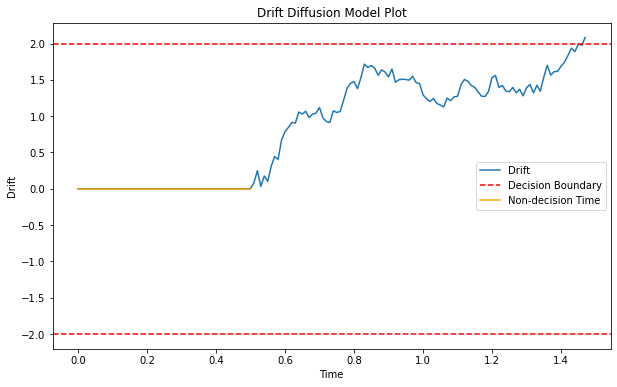

In [18]:

import matplotlib.pyplot as plt
from pyddm import Model
from pyddm.models import DriftConstant, BoundConstant, OverlayNonDecision,NoiseConstant


# Define the model
model = Model(drift=DriftConstant(drift=1), noise=NoiseConstant(noise=1), bound=BoundConstant(B=2), overlay=OverlayNonDecision(nondectime=0.5), dt=0.01, T_dur=2)

# Simulate a trial
s = model.simulate_trial()


# Extract drift and decision boundary
drift = s
bound = 2

# Get the time points with dt = 0.01 and T_dur = 1.5
time_points = model.t_domain()

plt.figure(figsize=(10, 6))
# Plot drift and decision boundary
plt.plot(time_points[0:len(drift)], drift, label='Drift')
plt.axhline(y=bound, color='r', linestyle='--', label='Decision Boundary')
plt.axhline(y=-bound, color='r', linestyle='--')
# Plot a green line for the first 0.5 seconds, labeled as non-decision time
plt.plot([0, 0.5], [0, 0], color='orange', label='Non-decision Time')
plt.xlabel('Time')
plt.ylabel('Drift')
plt.legend()
plt.title('Drift Diffusion Model Plot')
plt.show()

/tmp/ipykernel_33240/843116516.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_fits = pd.concat([data_fits, pd.DataFrame([[subject, condition['target_present'], condition['context_present'], 'slope', logarithmic_regression[1]], [subject, condition['target_present'], condition['context_present'], 'intercept', logarithmic_regression[0]]], columns=['ID','target_present', 'context_present', 'fit_parameter','value'])])
/tmp/ipykernel_33240/843116516.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat o

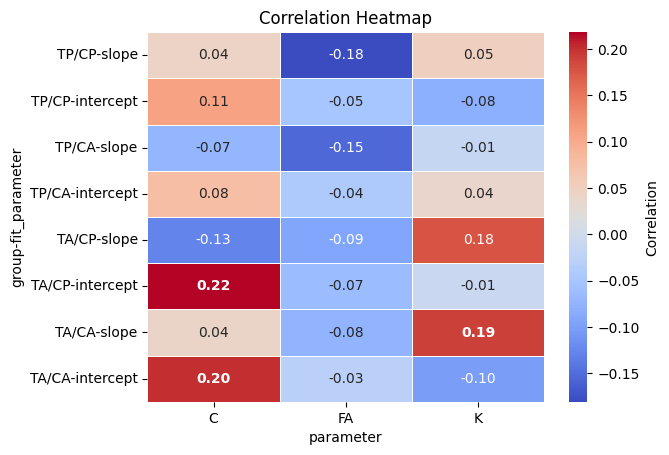

In [5]:
# Individual Differences
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns


# Load the data
data_CDT = pd.read_excel('main variables HS CDT GNG IUS.xlsx')
# Keep columns named "K", "FA_GNG", "c_GNG"
data_CDT = data_CDT[["ID","K", "FA_GNG", "c_GNG"]]
#Change column names to ID, K, FA, C
data_CDT.columns = ["ID","K", "FA", "C"]
# Column ID should be an integer
data_CDT['ID'] = data_CDT['ID'].astype(int)

# New dataframe with columns 'ID','target_present', 'context_present', 'fit_parameter','value'
data_fits = pd.DataFrame(columns=['ID','target_present', 'context_present', 'fit_parameter','value'])

grid = ParameterGrid({'vss': [4], 'context_present': [True, False], 'target_present': [True, False]})


MSS = np.array([1, 2, 4, 8])

for condition in grid:    
    filtered_data = correct_data[(correct_data.context_present == condition['context_present']) & (correct_data.target_present == condition['target_present']) & (correct_data.vss == condition['vss'])]
    # I need to fit a linear regression and a logarithmic regression to the data, grouped by subject and get the R2 of each subject, and then get the mean of the R2 of all subjects
    # First i need to get the rts of each subject
    rts_by_subject = filtered_data[['subject','rt','mss']].groupby('subject')
    # Then i needd to fit the linear regression and the logarithmic regression to the data of each subject
    linear_r2 = []
    logarithmic_r2 = []
    for subject, values in rts_by_subject:
        rt_means = []
        valid_mss = []
        for mss in MSS:
            # Get the mean of the rts grouped by mss
            rts = values[values.mss == mss][['rt','mss']].mean()
            if len(rts) > 0 and not np.isnan(rts.iloc[0]):
                rt_means.append(rts.iloc[0])
                valid_mss.append(mss)
        logarithmic_regression = np.poly1d(np.polyfit(np.log(valid_mss), rt_means, 1))
        # Update data_fits with the linear and logarithmic regression parameters
        data_fits = pd.concat([data_fits, pd.DataFrame([[subject, condition['target_present'], condition['context_present'], 'slope', logarithmic_regression[1]], [subject, condition['target_present'], condition['context_present'], 'intercept', logarithmic_regression[0]]], columns=['ID','target_present', 'context_present', 'fit_parameter','value'])])



# I need to get the correlation between each parameter and the slope and intercept of the linear and logarithmic regression, for each condition
correlation_df = pd.DataFrame(columns=['target_present', 'context_present', 'parameter','fit_parameter', 'correlation', 'p-value'])
for condition in grid:
    for parameter in ['K', 'FA', 'C']:
        for fit_parameter in ['slope', 'intercept']:            
            # Get the correlation between the parameter and the slope and intercept of the linear and logarithmic regression
            correlation = pearsonr(data_CDT[parameter], data_fits[(data_fits.target_present == condition['target_present']) & (data_fits.context_present == condition['context_present']) & (data_fits.fit_parameter == fit_parameter)]['value'])
            correlation_df = pd.concat([correlation_df, pd.DataFrame([[condition['target_present'], condition['context_present'], parameter, fit_parameter, correlation[0], correlation[1]]], columns=['target_present', 'context_present', 'parameter','fit_parameter', 'correlation', 'p-value'])])

# Change the values of 'target_present' column to 'TP' in case of True and 'TA' in case of False
correlation_df['target_present'] = correlation_df['target_present'].map({True: 'TP', False: 'TA'})
# Change the values of 'context_present' column to 'CP' in case of True and 'CA' in case of False
correlation_df['context_present'] = correlation_df['context_present'].map({True: 'CP', False: 'CA'})


# Create a new column for grouping
correlation_df['group'] = correlation_df['target_present'] + '/' + correlation_df['context_present']

# Set the index for the correlation dataframe
correlation_df = correlation_df.set_index(['group','fit_parameter','parameter'])

correlation_df = correlation_df.unstack()

new_order = [('TP/CP', 'slope'), ('TP/CP', 'intercept'), ('TP/CA', 'slope'), ('TP/CA', 'intercept'), ('TA/CP', 'slope'), ('TA/CP', 'intercept'), ('TA/CA', 'slope'), ('TA/CA', 'intercept')]

correlation_df = correlation_df.reindex(new_order)

# Plot heatmap with annotated values
heatmap = sns.heatmap(correlation_df['correlation'], annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'}, linewidths=0.5,fmt=".2f")

# Get the Axes object from the heatmap plot
ax = heatmap.axes

# Iterate over the values of the correlation_df['correlation'].unstack().T dataframe
for i in range(correlation_df['correlation'].shape[0]):
    for j in range(correlation_df['correlation'].shape[1]):
        # Get the text annotation
        text = ax.texts[i*correlation_df['correlation'].shape[1] + j]
        # Get the value from the correlation_df['correlation'].unstack().T dataframe
        value = correlation_df['correlation'].iloc[i,j]
        # Get the p-value from the correlation_df dataframe
        p_value = correlation_df['p-value'].iloc[i,j]
        # If the p-value is less than 0.05, set the text to bold
        if p_value < 0.05:
            text.set_weight('bold')

# Set plot title
plt.title('Correlation Heatmap')

# Show plot
plt.show()